In [1]:
!pip install -r requirements.txt

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance


# 資料前處理

In [0]:
def PreprocessedData(csvFile):
    dataset=pd.read_csv(csvFile)
    dataset['Up Or Down'] = dataset['Close Price'].diff()
    RSI=[np.nan for j in range(0,6)]
    for i in range(1,len(dataset)-5):
        up=0
        down=0
        for i in range(i,i+6):
            if(dataset['Up Or Down'][i]>0):
                up+=dataset['Up Or Down'][i]
            else:
                down+=abs(dataset['Up Or Down'][i])
        up/=6
        down/=6
        RSI.append((up/(up+down))*100)
    dataset['RSI']=RSI    
    
    EMA=[np.mean(dataset['Open Price'][0:2])]
    k=2/(6+1)
    for i in range(1,len(dataset)):
        EMA.append(dataset['Close Price'][i]*k+EMA[-1]*(1-k))
    dataset['EMA']=EMA        
    
    dataset['Close Delta'] = dataset['Close Price'].diff()
    dataset['Open Delta'] = dataset['Open Price'].diff()
    dataset['High Delta'] = dataset['High Price'].diff()
    dataset['Low Delta'] = dataset['Low Price'].diff()
    dataset['FI'] = dataset['Close Price'].diff()*dataset['Volume']

    dataset['Up Or Down'] = dataset['Close Price'].diff().shift(-1)
    dataset['Up Or Down'] = np.where(dataset['Up Or Down']>0,1,0)
    dataset = dataset.dropna()
    return dataset


train=PreprocessedData("stock_train.csv")
test=PreprocessedData("stock_test.csv")

* 處理feature部分: 除了原有的Date, Open Price,	Close Price, High Price, Low Price, Volume之外，我又多加了幾個feature，包括取各項feature今天和昨天的差值(Delta)，另外也上網查了一些投資人在看股票時會選擇的一些指標，例如:RSI, FI, EMA值。但其中以放入RSI值的效果最好。

  RSI簡介:
  1.   $公式=\frac{近期(6天)漲幅平均值}{近期(6天)漲幅平均值+近期(6天)跌幅平均值}\times{100}$
  2.   漲幅程度 > 跌幅程度: RSI值 > 50
     
     漲幅程度 < 跌幅程度: RSI值 < 50
  3. 當RSI值過高時投資人可能會開始擔心之後會不會大跌，就有可能不會再進場追高，或是早一步將股票售出、獲利了結，因而造成股價開始下跌。
  
  FI簡介:
  1.   $公式={(今日收盤價-昨日收盤價)}\times{交易量}$
  2.   主要用來追蹤漲勢多頭力道和跌勢的空頭力道，屬於擺盪指標的一種，加入了成交量的概念，並非只是價格的變動。
  3.   會選這個feature主要是因為我在網絡上有看到一樣也是用xgboost來預測漲或跌的正確率有70幾%，而它的feature importance中分數最高的就是這項指標，但我自己試著放進訓練正確率並沒有顯著的提升。

  EMA簡介:
  1.   $公式={今日收盤價}\times{k}+{昨日收盤價}\times{(1-k)}$
       
       $k=\frac{2}{選擇天數+1}$
  2.   全名為:指數加權移動平均。會考慮不同時期的價格對現在的影響，也就是近期數據對價格的權重影響較高，較sma反應快速。

  3.   但是這項feature套入feature importance後的分數都不高，而且都會讓xgboost需要的樹的數量變多。

* 處理target部分:計算明天的收盤價與今天的收盤價差值，若差值為正則設1，差值為負則設0。






In [4]:
train

,Date,Open Price,Close Price,High Price,Low Price,Volume,Up Or Down,RSI,EMA,Close Delta,Open Delta,High Delta,Low Delta,FI
6,12-Jan-2009,890.40,870.26,890.40,864.32,4725049856,1,12.566910,897.818873,-20.09,-19.51,-21.53,-23.99,-9.492625e+10
7,13-Jan-2009,869.79,871.79,877.02,862.02,5017469952,0,14.940791,890.382052,1.53,-20.61,-13.38,-2.30,7.676729e+09
8,14-Jan-2009,867.28,842.62,867.28,836.93,5407880192,1,4.550839,876.735752,-29.17,-2.51,-9.74,-25.09,-1.577479e+11
9,15-Jan-2009,841.99,843.74,851.59,817.04,7807350272,1,7.704720,867.308394,1.12,-25.29,-15.69,-19.89,8.744232e+09
10,16-Jan-2009,844.45,850.12,858.13,830.66,6786039808,0,11.626110,862.397424,6.38,2.46,6.54,13.62,4.329493e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,22-Dec-2017,2684.22,2683.34,2685.35,2678.13,1383888512,0,78.169394,2678.886285,-1.23,1.20,-7.29,-4.27,-1.702183e+09
2260,26-Dec-2017,2679.09,2680.50,2682.74,2677.96,1103808384,1,56.767677,2679.347346,-2.84,-5.13,-2.61,-0.17,-3.134816e+09
2261,27-Dec-2017,2682.10,2682.62,2685.64,2678.91,1149108352,1,33.184657,2680.282390,2.12,3.01,2.90,0.95,2.436110e+09
2262,28-Dec-2017,2686.10,2687.54,2687.66,2682.69,1126089856,0,66.273458,2682.355993,4.92,4.00,2.02,3.78,5.540362e+09


In [5]:
test

,Date,Open Price,Close Price,High Price,Low Price,Volume,Up Or Down,RSI,EMA,Close Delta,Open Delta,High Delta,Low Delta,FI
6,2-Jan-18,2683.73,2695.81,2695.89,2682.36,1846463232,1,61.896698,2685.280384,22.20,-5.42,3.77,8.75,4.099148e+10
7,3-Jan-18,2697.85,2713.06,2714.37,2697.77,2090595328,1,73.490357,2693.217417,17.25,14.12,18.48,15.41,3.606277e+10
8,4-Jan-18,2719.31,2723.99,2729.29,2719.07,2100767744,1,80.476524,2702.009584,10.93,21.46,14.92,21.30,2.296139e+10
9,5-Jan-18,2731.33,2743.15,2743.45,2727.92,1918869120,1,84.240299,2713.763988,19.16,12.02,14.16,8.85,3.676553e+10
10,8-Jan-18,2742.67,2747.71,2748.51,2737.60,1894823936,1,84.175849,2723.462849,4.56,11.34,5.06,9.68,8.640397e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,24-Dec-18,2400.56,2351.10,2410.34,2351.10,1662758784,1,0.088251,2461.052406,-65.52,-64.82,-94.07,-57.45,-1.089440e+11
254,26-Dec-18,2363.12,2467.70,2467.76,2346.58,2611875072,1,37.456714,2462.951719,116.60,-37.44,57.42,-4.52,3.045446e+11
255,27-Dec-18,2442.50,2488.83,2489.10,2397.94,2386466304,0,41.386460,2470.345513,21.13,79.38,21.34,51.36,5.042603e+10
256,28-Dec-18,2498.77,2485.74,2520.27,2472.89,2080726656,1,46.423756,2474.743938,-3.09,56.27,31.17,74.95,-6.429445e+09


# Xgboost

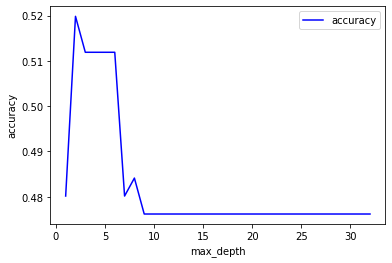

Model Accuracy		:  0.5198412698412699


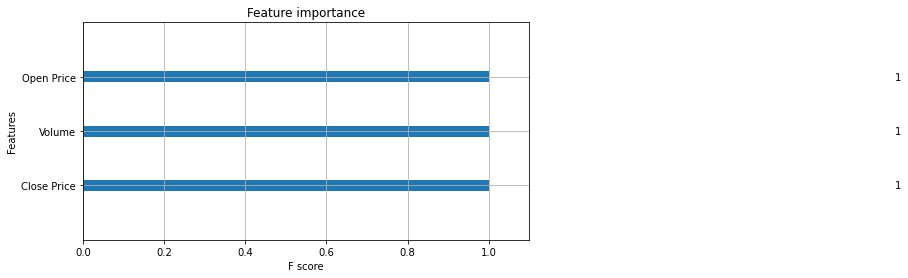

In [6]:
def DrawXgboostRes(KeepCols):
  Y_train=np.array(train['Up Or Down'])
  X_train=np.array(train[KeepCols])

  Y_test=np.array(test['Up Or Down'])
  X_test=np.array(test[KeepCols])

  n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200,300,400,500,600,700,800]  ## try different n_estimators
  results=[]
  for estimator in n_estimators:
      model = XGBClassifier(n_estimators=estimator)
      model.fit(X_train,Y_train)
      Y_pred=model.predict(X_test)
      acc = metrics.accuracy_score(Y_pred,Y_test)
      results.append(acc)

  best_n_estimators = n_estimators[results.index(max(results))]

  results=[]
  max_depths = np.linspace(1, 32, 32, endpoint=True).astype(int)  ## try different max_depths
  for max_depth in max_depths:
      model = XGBClassifier(n_estimators = best_n_estimators, max_depth=max_depth)
      model.fit(X_train,Y_train)
      Y_pred=model.predict(X_test)
      acc = metrics.accuracy_score(Y_pred,Y_test)
      results.append(acc)

  best_max_depth = max_depths[results.index(max(results))]
  line1= plt.plot(max_depths, results, 'b', label="accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('max_depth')
  plt.legend()
  plt.show()

  model = XGBClassifier(n_estimators = best_n_estimators, max_depth=best_max_depth)
  model.fit(X_train,Y_train)
  Y_pred=model.predict(X_test)

  #draw feature importance
  model.get_booster().feature_names = KeepCols
  tryit = plot_importance(model.get_booster())
  tryit.figure.set_size_inches(8,4)
  
  print("Model Accuracy\t\t: ",metrics.accuracy_score(Y_pred,Y_test))
  

DrawXgboostRes(['Open Price','Close Price','High Price','Low Price','Volume'])


1.一開始主要先拿除了"Date"的原始幾個feature下去做訓練，並嘗試各種max_death與n_estimators來找出最高的正確率。

2.此外也畫出feature importance來找出哪幾項feature是對訓練的結果較有幫助的，而從上面的圖可以看出High Price與Low Price的分數較低。

3.testing data的正確率約為52%

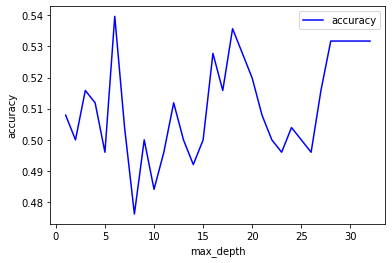

Model Accuracy		:  0.5396825396825397


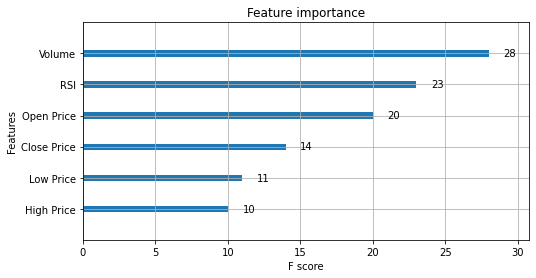

In [7]:
DrawXgboostRes(['Open Price','Close Price','High Price','Low Price','Volume','RSI'])

1.接著多加RSI下去訓練，正確率有稍微提高。

2.從feature importance可以看出RSI這項feature的重要性排在第二，代表加入這項feature對模型的訓練是有幫助的。

3.testing data正確率約為54%

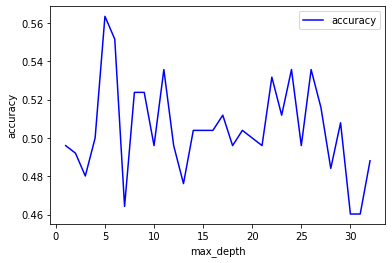

Model Accuracy		:  0.5634920634920635


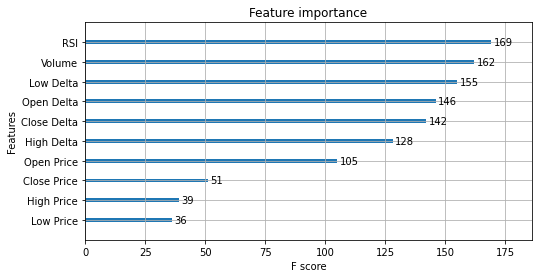

In [8]:
DrawXgboostRes(['Open Price','Close Price','High Price','Low Price','Volume','RSI','Close Delta','Open Delta','High Delta','Low Delta'])


1.接著再把Delta也加下去訓練，正確率又再略微提高。

2.從feature importance可以看出Delta的這幾項features的分數都蠻高的，較原本的feature對模型的訓練有更顯著的影響。

3.testing data的正確率為56.3%

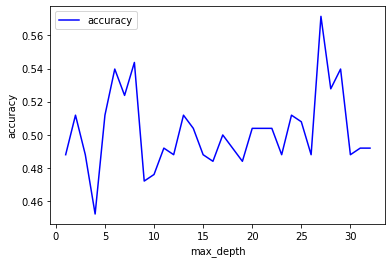

Model Accuracy		:  0.5714285714285714


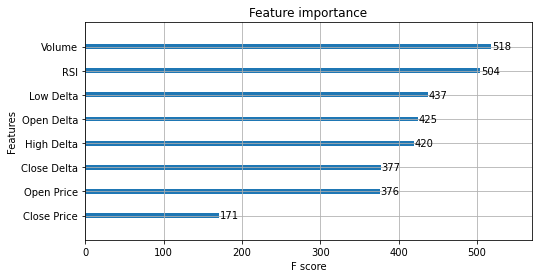

In [9]:
DrawXgboostRes(['Open Price','Close Price','Volume','RSI','Close Delta','Open Delta','High Delta','Low Delta'])

1.因為前幾次的feature importance圖都顯示High Price跟Low Price的重要性較低，因此將這兩項feature拿掉來訓練看看，發現確實正確率有再略微提高。

2.testing data的正確率約為57.1%

# Logistic Regression

In [10]:
Y_train=np.array(train['Up Or Down'])
X_train=np.array(train[['Open Price','Close Price','Volume','RSI','Close Delta','Open Delta','High Delta','Low Delta']])

Y_test=np.array(test['Up Or Down'])
X_test=np.array(test[['Open Price','Close Price','Volume','RSI','Close Delta','Open Delta','High Delta','Low Delta']])

model=LogisticRegression()
model.fit(X_train,Y_train)
Y_pred=model.predict(X_test)
print("Model Accuracy\t\t: ",metrics.accuracy_score(Y_pred,Y_test))

Model Accuracy		:  0.5198412698412699


1.而Logistic Regression主要我是基於Xgboost找到較為重要的feature下去做訓練。

2.testing data正確率約為:52%

In [11]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print("Model Accuracy\t\t: ",metrics.accuracy_score(Y_pred,Y_test))


Model Accuracy		:  0.5198412698412699


Logistic Regression我有跑grid search改變C值去找最大的正確率，但正確率跑出來都是一樣的值。

# LSTM

In [0]:
Y_train=np.array(train['Up Or Down'])
X_train=np.array(train[['Open Price','Close Price','Volume','RSI','Close Delta','Open Delta','High Delta','Low Delta','EMA']])

#normalize
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)

X_lstm_train = []
Y_lstm_train = []
for i in range(6,X_train.shape[0]):
  X_lstm_train.append(X_train[i-6:i])
  Y_lstm_train.append(Y_train[i-1])

X_lstm_train = np.array(X_lstm_train)
Y_lstm_train = np.array(Y_lstm_train)  


In [0]:
Y_test=np.array(test['Up Or Down'])
X_test=np.array(test[['Open Price','Close Price','Volume','RSI','Close Delta','Open Delta','High Delta','Low Delta','EMA']])

#normalize
X_test = X_scaler.fit_transform(X_test)

X_lstm_test = []
Y_lstm_test = []
for i in range(6,test.shape[0]):
  X_lstm_test.append(X_test[i-6:i])
  Y_lstm_test.append(Y_test[i-1])

X_lstm_test = np.array(X_lstm_test)
Y_lstm_test = np.array(Y_lstm_test)

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,GRU

model = Sequential()
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_lstm_train.shape[1], X_lstm_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 40, activation = 'softmax', return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 60)             16800     
_________________________________________________________________
dropout (Dropout)            (None, 6, 60)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                16160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 33,001
Trainable params: 33,001
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
adam = optimizers.Adam(lr=0.001)
model.compile(loss="BinaryCrossentropy", optimizer=adam,metrics=['binary_accuracy'])
history=model.fit(X_lstm_train, Y_lstm_train, epochs=100, batch_size=16,validation_data=(X_lstm_test, Y_lstm_test),callbacks=[callback])

Epoch 1/100
141/141 [==============================] - 1s 10ms/step - loss: 1.5469 - binary_accuracy: 0.4534 - val_loss: 0.7336 - val_binary_accuracy: 0.4878
Epoch 2/100
141/141 [==============================] - 1s 7ms/step - loss: 0.8420 - binary_accuracy: 0.4600 - val_loss: 0.7136 - val_binary_accuracy: 0.4878
Epoch 3/100
141/141 [==============================] - 1s 7ms/step - loss: 0.7999 - binary_accuracy: 0.5018 - val_loss: 0.7053 - val_binary_accuracy: 0.4878
Epoch 4/100
141/141 [==============================] - 1s 8ms/step - loss: 0.8116 - binary_accuracy: 0.4711 - val_loss: 0.7045 - val_binary_accuracy: 0.4878
Epoch 5/100
141/141 [==============================] - 1s 8ms/step - loss: 0.7809 - binary_accuracy: 0.5093 - val_loss: 0.7024 - val_binary_accuracy: 0.4878
Epoch 6/100
141/141 [==============================] - 1s 8ms/step - loss: 0.7639 - binary_accuracy: 0.5155 - val_loss: 0.7062 - val_binary_accuracy: 0.4878
Epoch 7/100
141/141 [==============================] - 1s

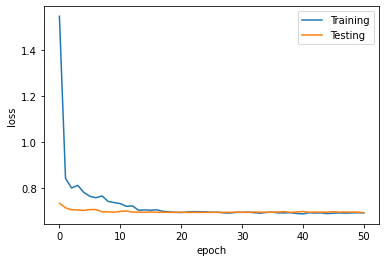

In [16]:
plt.plot(history.history['loss'],  label='Training')
plt.plot(history.history['val_loss'],  label='Testing')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

1.RSI我是用6天的漲幅下去算，所以在lstm選擇一筆資料要訓練的天數也是設為6天，又因為要取6天的資料量才能做預測，因此test data我有少放最一開始的6筆資料下去做預測。

2.在feature的選擇上除了之前xgboost預測出最好正確率的feature外，我還加了EMA下去預測，對LSTM的訓練似乎較有幫助。 

3.去對lstm調整參數(ex:層數、神經元數、optimizers、epochs數)，最後得到的正確率為51.22%

# 比較3種模型結果
1. Xgboost是這三個分類器中正確率最高的模型，主要因為它是透過將許多弱分類器集合進行Boosting的強化模型訓練方式，會將每次的結果進行殘差運算， 針對殘差補入新的弱分類器強化，且不只運用一階線性關係，更透過微分進行泰勒展開，藉此導入梯度的概念，能夠有目的且有效率的訓練出我們所需的模型。
2. 我認為換了其他的dataset可能沒辦法有一樣的結果，首先我覺得股票的預測真的相對困難很多，即使我加了很多股票會看的指標希望找出對上漲與下跌的預測更有幫助的feature，但是正確率都還是只有在五成左右，可見模型其實還是沒有學到太多有用的特徵，即便是同樣資料集的data下去訓練與預測最高也只有57%左右的正確率，可想而知其他資料集的預測也不會有太好的結果。


# 小結
這次真的花了很多時間在研究怎麼讓正確率變高，除了去看很多相關的股票指標外，也分別用Xgboost跟lstm回歸的方式去預測明天的股價，Xgboost雖然預測出來曲線與實際曲線很像，但是曲線會向右偏，lstm的曲線則是沒有與實際曲線很像，但是也會有偏移的問題。
* Xgboost:
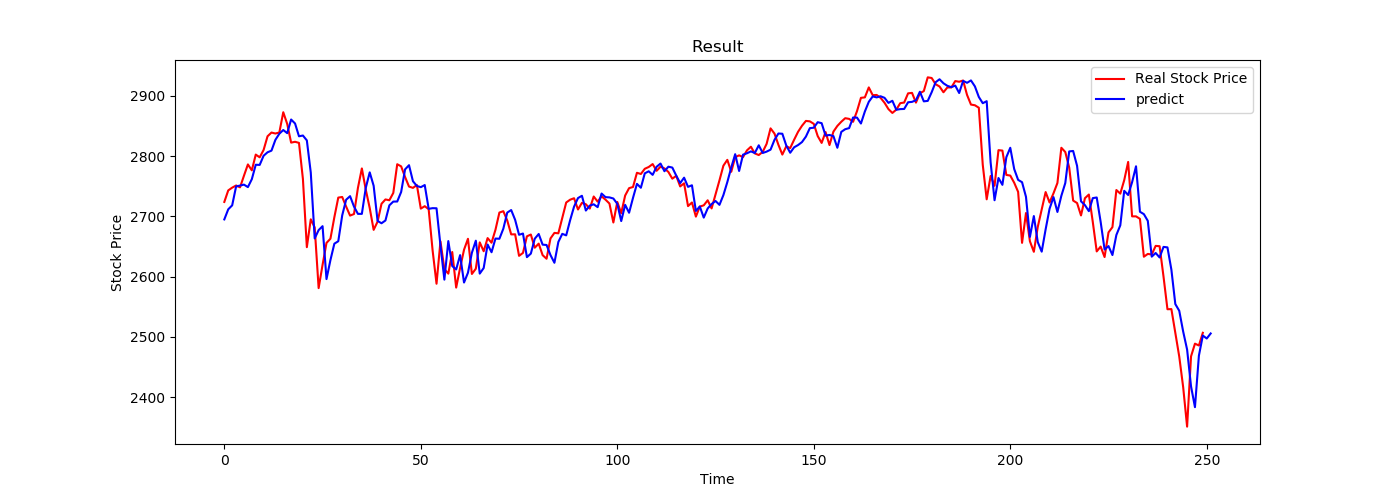


* lstm:
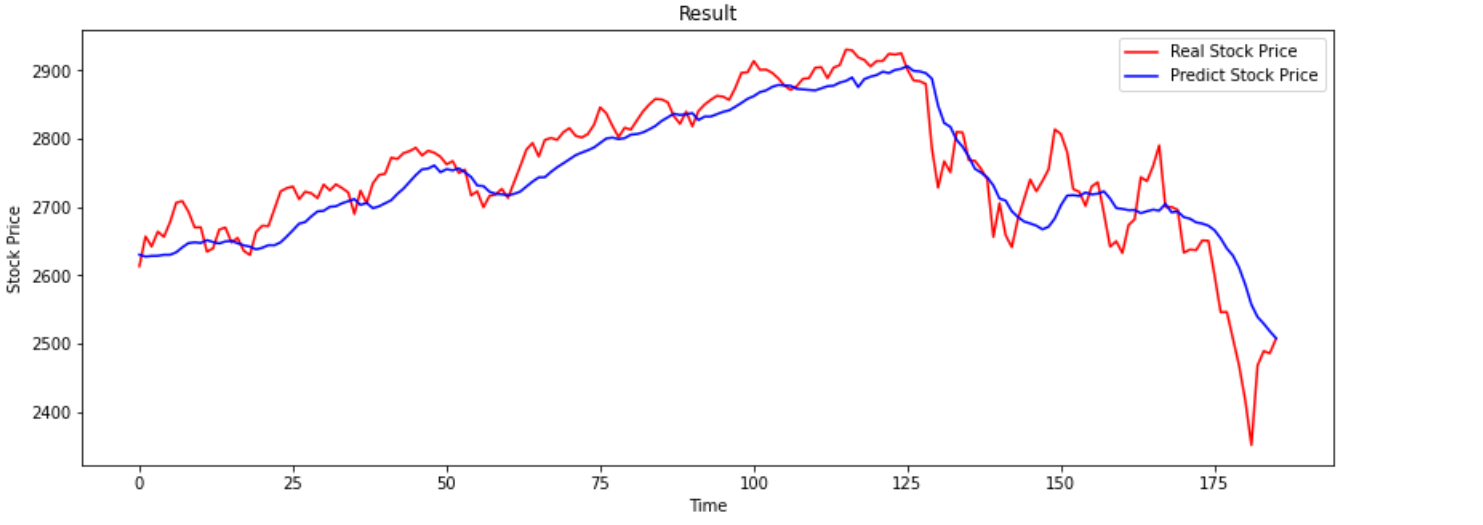